# Our key questions are:
1. Are we seeing any lead quality trends over time (improving, declining)? Are they statistically
significant?
2. What can we learn about the drivers of "lead quality" from this dataset? What segments -
where the ad was shown, what kind of person filled out the ad, what kind of ad did they see -
have differing lead quality rates?
3. If the advertiser says they will increase our CPL by 20% (i.e., $30 to $33) if we increase our
lead quality by 20% (i.e., from 8.0% to 9.6%), do we see any opportunities to do that here? What kinds of things could we do?

# Lead Quality Trends and Statistical Significance

## Analysis Approach and Rationale

In [314]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats

# Read the data
file_path = 'Analyst case study dataset 1.xlsx'
df = pd.read_excel(file_path)

# Define the Lead Quality classification logic
def classify_lead_quality(status):
    if pd.isnull(status):
        return "Unknown"  # If the status is missing, classify it as "Unknown"
    elif "Closed" in status:
        return "High Quality"  # If the status contains "Closed", classify it as "High Quality"
    elif "EP Sent" in status or "EP Received" in status or "EP Confirmed" in status:
        return "Medium Quality"  # If the status contains any of these, classify it as "Medium Quality"
    elif "Unable to contact" in status or "Invalid Profile" in status or "Doesn't Qualify" in status:
        return "Low Quality"  # If the status contains any of these, classify it as "Low Quality"
    else:
        return "Unknown"  # If the status does not match any condition, classify it as "Unknown"

# Apply the classification function
df["LeadQuality"] = df["CallStatus"].apply(classify_lead_quality)

# Convert date format
df["LeadCreated"] = pd.to_datetime(df["LeadCreated"])  # Convert the "LeadCreated" column to datetime format
df["Month"] = df["LeadCreated"].dt.to_period("M")  # Extract the year and month as a period

df

,LeadCreated,FirstName,Email,VendorLeadID,CallStatus,WidgetName,PublisherZoneName,PublisherCampaignName,AddressScore,PhoneScore,...,MarketingCampaign,AdGroup,Keyword,SearchQuery,ReferralURL,ReferralURL Parameters,LandingPageURL,Landing Page URL Parameters,LeadQuality,Month
0,2009-07-01 01:24:29.563,Dorinda,kanani@sandwichisles.net,FDF81FDA-A649-437B-B99C-FDDE74F7971B,NaN,w-302252-DebtReduction1-1DC-CreditSolutions,TopLeft-302252,DebtReductionInc,NaN,5.0,...,Debt Holding Tank,Holding Tank - Debt,Debt specialists,debt specialists,http://www.google.com/search,sourceid=navclient&aq=1&oq=debt sp&ie=UTF-8&rl...,http://www.debtreductioninc.com/index8.html,utm_source=google&utm_medium=CPC&utm_content=H...,Unknown,2009-07
1,2009-04-13 15:27:35.990,Presetta,clerk2@ustconline.net,4190ACB7-5026-416C-B987-ED8AD427D5E6,NaN,w-300250-DebtReduction1-1DC-Head2,TopLeft-302252,DebtReductionInc,NaN,NaN,...,Financial Services,Consolidate,NaN,NaN,NaN,NaN,http://www.debtreductioninc.com/index8.html,utm_source=AdKnowledge&utm_medium=CPC&utm_cont...,Unknown,2009-04
2,2009-04-21 07:22:59.000,Gina,wagoner_gina@yahoo.com,hFg80jf_R0CRN55hdhWILw,Unable to contact - Bad Contact Information,w-300250-DebtReduction1-1DC-Head2,TopLeft-302252,DebtReductionInc,NaN,NaN,...,Financial Services,Consolidate,NaN,NaN,http://us.mc582.mail.yahoo.com/mc/showMessage,&fid=Inbox&sort=date&order=down&startMid=0&.ra...,http://www.debtreductioninc.com/index8.html,utm_source=AdKnowledge&utm_medium=CPC&utm_cont...,Low Quality,2009-04
3,2009-08-03 19:39:02.000,Kari,usa4ley@yahoo.com,jB01QgYZxkWArI9jWxuufw,Contacted - Doesn't Qualify,w-302252-DebtReduction1-1DC-white,TopLeft-302252,DebtReductionInc,5.0,3.0,...,DebtReductionInc,Lower Payments,NaN,NaN,http://norwich.kijiji.com/c-Cars-vehicles-Cars...,NaN,http://www.debtreductioninc.com/index12.html,utm_source=Google&utm_medium=cpc&utm_campaign=...,Low Quality,2009-08
4,2009-04-13 10:18:37.490,Stephanie,sr1lambert@embarqmail.com,D5B32074-458E-40EC-B185-1FEF20AC626D,NaN,w-300250-DebtReduction1-1DC-BlueMeter,TopLeft-302252,DebtReductionInc,NaN,NaN,...,DebtReductionInc,Debt Reduction,NaN,NaN,NaN,NaN,http://www.debtreductioninc.com/index8.html,utm_source=Google&utm_medium=cpc&utm_campaign=...,Unknown,2009-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3016,2009-06-30 18:14:33.043,amy,ahokett@sjc.edu,F42BBDFB-D44B-4890-A1B6-D1F0A3838214,NaN,w-302252-DebtReduction1-1DC-white,TopLeft-302252,DebtReductionInc,NaN,NaN,...,DebtReductionInc,Debt Consolidation,NaN,NaN,http://www.att.net/s/s.dll,spage=search/error.htm&searchtype=epa&source=a...,http://www.debtreductioninc.com/index8.html,utm_source=yahoo&utm_medium=cpc&utm_campaign=D...,Unknown,2009-06
3017,2009-04-25 16:56:53.670,brandy,brandy75137@yahoo.com,EA3703A3-61C9-40CE-92F7-61F0E02B1365,NaN,w-300250-DebtReduction1-1DC-Head2,TopLeft-302252,DebtReductionInc,NaN,NaN,...,DebtReductionInc,Student Debt,NaN,NaN,http://googleads.g.doubleclick.net/pagead/ads,client=ca-pub-7025449865608971&dt=124069479896...,http://www.debtreductioninc.com/index8.html,utm_source=Google&utm_medium=cpc&utm_campaign=...,Unknown,2009-04
3018,2009-04-12 18:38:43.067,jennifer,jennifer_woods48375@yahoo.com,64EB2632-E29E-4EB4-B361-45F1F0C735B5,NaN,w-300250-DebtReduction1-1DC-CreditSolutions,TopLeft-302252,DebtReductionInc,NaN,NaN,...,DebtReductionInc,Debt Consolidation,NaN,debt consolidation or settlement which is better,http://search.yahoo.com/search,ei=UTF-8&fr=yfp-t-501&SpellState=n-1665662351_...,http://www.debtreductioninc.com/index8.html,utm_source=yahoo&utm_medium=cpc&utm_campaign=D...,Unknown,2009-04
3019,2009-09-23 21:41:08.193,debra,debraroque@att.net,9126C7DB-F5BB-4CE1-BDCF-5E6F1841ADAD,NaN,w-302252-DebtReduction1-1DC-yellowarrow-dark,TopLeft-302252,DebtReductionInc,5.0,5.0,...,state,Debt Negotiation,NaN,NaN,NaN,NaN,http://www.debtreductioninc.com/index8.html,utm_source=Google&utm_medium=cpc&utm_campaign=...,Unknown,2009-09


In [315]:
# Compute Total Leads per month (excluding "Unknown")
total_leads_df = df[df["LeadQuality"] != "Unknown"].groupby("Month")["LeadQuality"].count().reset_index()

# Rename the column for clarity
total_leads_df.rename(columns={"LeadQuality": "Total Leads"}, inplace=True)
total_leads_df

,Month,Total Leads
0,2009-04,136
1,2009-05,116
2,2009-06,227
3,2009-07,159
4,2009-08,129
5,2009-09,114


## Lead Quality Trends & Key Observations

In [316]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import kruskal, f_oneway

# Convert Lead Created Time to numeric (days since first record)
df["LeadCreated_Num"] = (df["LeadCreated"] - df["LeadCreated"].min()).dt.total_seconds()

# Convert Lead Quality into numerical scores
type_score_map = {"High Quality": 2, "Medium Quality": 1, "Low Quality": 0, "Unknown": np.nan}
df["LeadQuality_Score"] = df["LeadQuality"].map(type_score_map)

# Drop unknown values for statistical tests
df_filtered = df.dropna(subset=["LeadQuality_Score"])


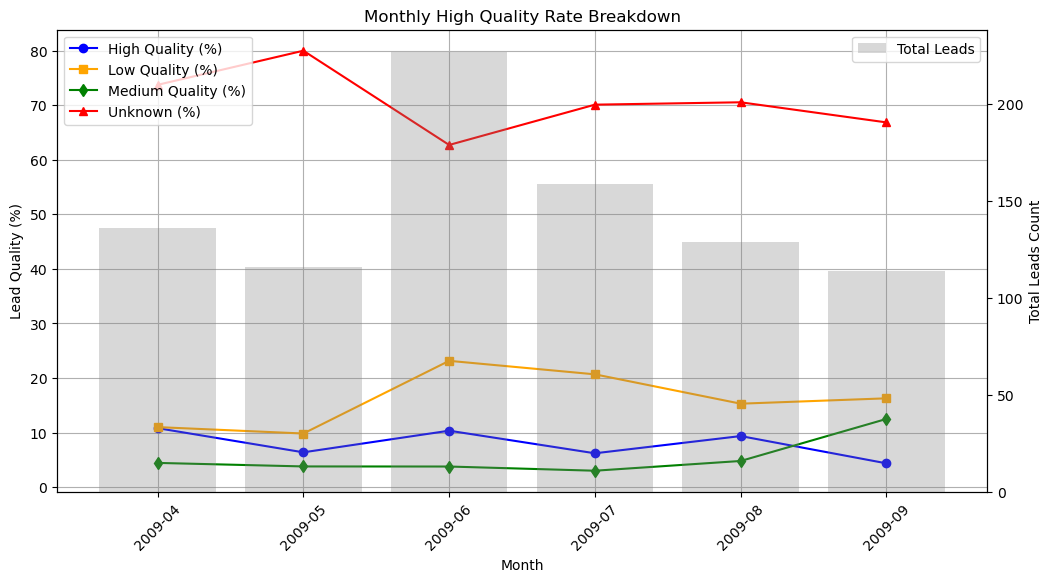

In [317]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Compute Lead Quality percentage by month
lead_quality_trend = df.groupby(["Month", "LeadQuality"]).size().unstack()
lead_quality_trend_percentage = lead_quality_trend.div(lead_quality_trend.sum(axis=1), axis=0) * 100

# Compute Total Leads per month (excluding "Unknown")
total_leads_df = df[df["LeadQuality"] != "Unknown"].groupby("Month")["LeadQuality"].count().reset_index()
total_leads_df.rename(columns={"LeadQuality": "Total Leads"}, inplace=True)

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))  # Define the primary axis for the line chart

# Bar chart (Total Leads)
ax2 = ax1.twinx()  # Create a secondary y-axis for Total Leads
ax2.bar(total_leads_df["Month"].astype(str), 
        total_leads_df["Total Leads"], 
        color="gray", alpha=0.3, label="Total Leads")

# Line charts for Lead Quality percentages
colors = ["blue", "orange", "green", "red"]  # Define colors for line plots
markers = ["o", "s", "d", "^"]  # Define markers for better visibility

for idx, category in enumerate(lead_quality_trend_percentage.columns):
    ax1.plot(lead_quality_trend_percentage.index.astype(str), 
             lead_quality_trend_percentage[category], 
             marker=markers[idx], 
             label=f"{category} (%)", 
             color=colors[idx])

# Titles and Labels
ax1.set_title("Monthly High Quality Rate Breakdown")
ax1.set_xlabel("Month")
ax1.set_ylabel("Lead Quality (%)")
ax2.set_ylabel("Total Leads Count")

# Legends and Grid
ax1.legend(loc="upper left")
ax2.legend(["Total Leads"], loc="upper right")
ax1.grid(True)
ax1.tick_params(axis='x', rotation=45)

# Show the plot
plt.show()


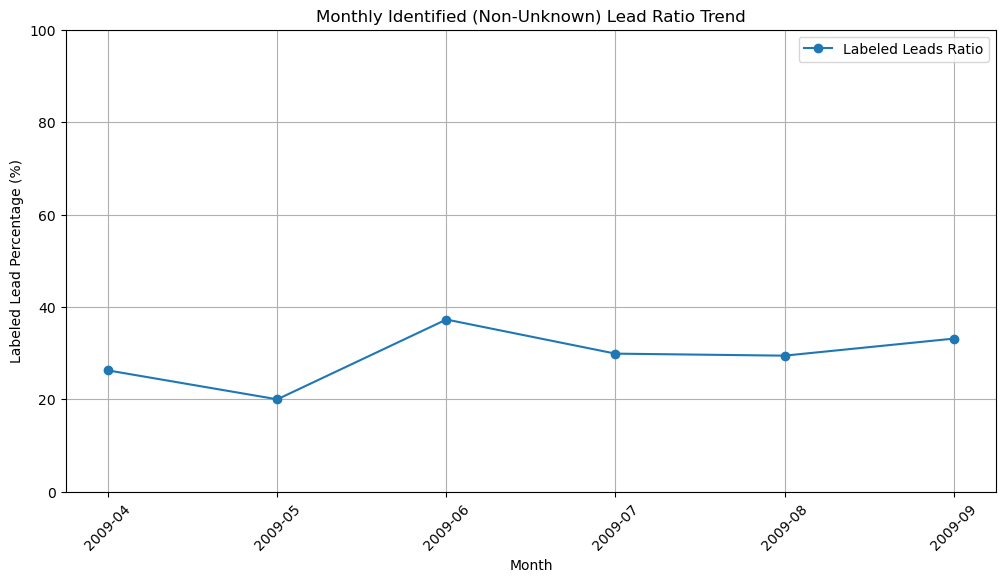

In [318]:
# Compute the proportion of labeled (non-Unknown) Leads per month
df["IsLabeled"] = df["LeadQuality"] != "Unknown"
labeled_ratio_trend = df.groupby("Month")["IsLabeled"].mean() * 100  

# Plot trend line chart
plt.figure(figsize=(12, 6))
plt.plot(labeled_ratio_trend.index.astype(str), labeled_ratio_trend, marker="o", linestyle="-", label="Labeled Leads Ratio")
plt.title("Monthly Identified (Non-Unknown) Lead Ratio Trend")
plt.xlabel("Month")
plt.ylabel("Labeled Lead Percentage (%)")
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.legend()
plt.grid(True)
plt.show()

## Statistical Analysis Validation

In [319]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import kruskal, f_oneway

df["LeadCreated_Num"] = (df["LeadCreated"] - df["LeadCreated"].min()).dt.days


# Drop unknown values for statistical tests
df_filtered = df.dropna(subset=["LeadQuality_Score"])


In [320]:
# Define independent (X) and dependent (y) variables
X = sm.add_constant(df_filtered["LeadCreated_Num"])  # Add intercept term
y = df_filtered["LeadQuality_Score"]

# Fit Linear Regression Model
model = sm.OLS(y, X).fit()

# Print Summary of Regression
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:      LeadQuality_Score   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     12.42
Date:                Fri, 21 Feb 2025   Prob (F-statistic):           0.000446
Time:                        16:45:26   Log-Likelihood:                -1120.6
No. Observations:                 881   AIC:                             2245.
Df Residuals:                     879   BIC:                             2255.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.9075      0.060     

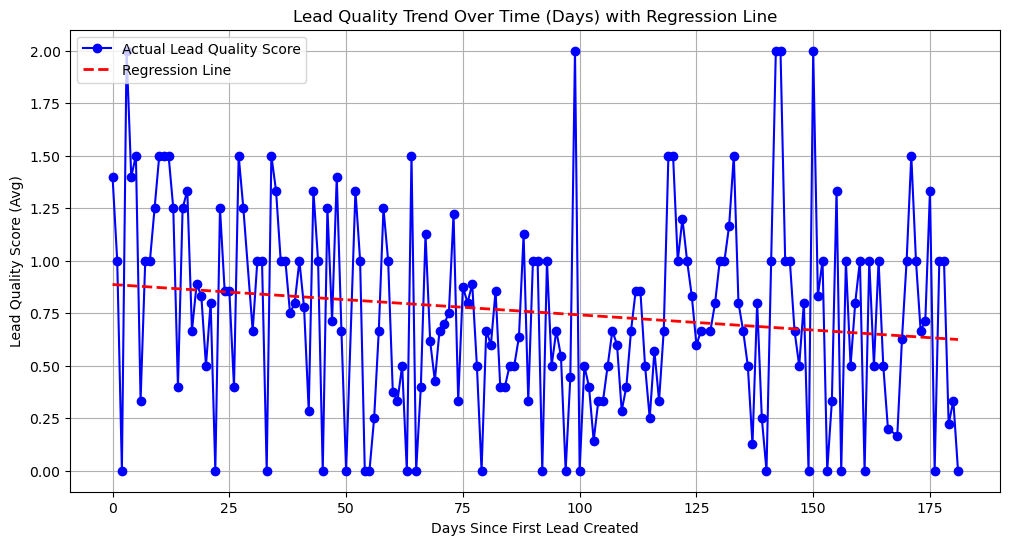

In [321]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import statsmodels.api as sm


# Group by days and compute the average Lead Quality Score per day
daily_avg_score = df_filtered.groupby("LeadCreated_Num")["LeadQuality_Score"].mean().reset_index()

# Define independent (X) and dependent (y) variables
X = sm.add_constant(daily_avg_score["LeadCreated_Num"])  # Add intercept term
y = daily_avg_score["LeadQuality_Score"]

# Fit Linear Regression Model
model = sm.OLS(y, X).fit()

# Generate predictions for plotting
daily_avg_score["Predicted_Score"] = model.predict(X)

# Plot actual data trend (blue line) and regression line (red)
plt.figure(figsize=(12, 6))

# Actual trend line (daily average Lead Quality Score)
plt.plot(daily_avg_score["LeadCreated_Num"], daily_avg_score["LeadQuality_Score"], marker="o", linestyle="-", color="blue", label="Actual Lead Quality Score")

# Regression line (Predicted Lead Quality Score)
plt.plot(daily_avg_score["LeadCreated_Num"], daily_avg_score["Predicted_Score"], color="red", linestyle="--", linewidth=2, label="Regression Line")

# Labels and Title
plt.xlabel("Days Since First Lead Created")
plt.ylabel("Lead Quality Score (Avg)")
plt.title("Lead Quality Trend Over Time (Days) with Regression Line")
plt.legend()
plt.grid(True)

# Show plot
plt.show()


# Lead Quality Trends and Statistical Significance

In [322]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier

# Standardize Debt Level categories
debt_level_mapping = {
    '7500-10000': '7500-15000',
    '7500-15000': '7500-15000',
    '10001-15000': '10001-20000',
    '15001-20000': '10001-20000',
    '20001-30000': '20001-30000',
    '30001-50000': '30001-50000',
    '50001-70000': '50001-70000',
    '70001-90000': '70001-100000',
    '90000-100000': '70001-100000',
    'More_than_100000': 'More_than_100000'
}
df["DebtLevel"] = df["DebtLevel"].replace(debt_level_mapping)

# Normalize Partner column
df["Partner"] = df["Partner"].str.lower()

# Filter out "Unknown" Lead Quality
df_filtered = df[df["LeadQuality"] != "Unknown"]

# Encode categorical variables
categorical_features = ["Partner", "WidgetName", "DebtLevel", "PublisherZoneName", "AdvertiserCampaignName"]
encoder = {col: LabelEncoder() for col in categorical_features}
for col in categorical_features:
    df_filtered[col] = encoder[col].fit_transform(df_filtered[col])

# **Use LeadQuality_Score directly instead of encoding LeadQuality**
y = df_filtered["LeadQuality_Score"]

# Chi-Square Test for Feature Significance
chi_square_results = {}
for feature in categorical_features:
    contingency_table = pd.crosstab(df_filtered[feature], y)
    chi2, p, _, _ = stats.chi2_contingency(contingency_table)
    chi_square_results[feature] = {"Chi-Square": chi2, "p-value": p}
chi_square_df = pd.DataFrame.from_dict(chi_square_results, orient="index")

# Train-Test Split
X = df_filtered[categorical_features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
feature_importances_rf = pd.DataFrame({"Feature": categorical_features, "Importance": rf_model.feature_importances_}).sort_values(by="Importance", ascending=False)

# Train XGBoost Classifier
xgb_model = XGBClassifier(n_estimators=400, learning_rate=0.02, max_depth=10, 
                          min_child_weight=4, gamma=0.3, subsample=0.80, colsample_bytree=0.80, 
                          reg_lambda=2.0, reg_alpha=0.1, random_state=42, eval_metric="mlogloss", use_label_encoder=False)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
feature_importances_xgb = pd.DataFrame({"Feature": categorical_features, "Importance": xgb_model.feature_importances_}).sort_values(by="Importance", ascending=False)

# Display Model Accuracy
print("Random Forest Accuracy:", rf_accuracy)
print("XGBoost Accuracy:", xgb_accuracy)


/var/folders/x4/d6zk2cgs5wzgy4stqr5p1jp00000gn/T/ipykernel_87137/2201654838.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[col] = encoder[col].fit_transform(df_filtered[col])
/var/folders/x4/d6zk2cgs5wzgy4stqr5p1jp00000gn/T/ipykernel_87137/2201654838.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered[col] = encoder[col].fit_transform(df_filtered[col])
/var/folders/x4/d6zk2cgs5wzgy4stqr5p1jp00000gn/T/ipykernel_87137/2201654838.py:38: SettingWithCopyWarning: 
A value is trying 

Random Forest Accuracy: 0.5141242937853108
XGBoost Accuracy: 0.559322033898305


In [323]:
chi_square_df

,Chi-Square,p-value
Partner,17.381454,0.026373
WidgetName,60.784887,0.000131
DebtLevel,40.523098,0.000059
PublisherZoneName,1.283165,0.526459
AdvertiserCampaignName,0.775687,0.678519


In [324]:
feature_importances_rf

,Feature,Importance
1,WidgetName,0.404209
2,DebtLevel,0.383244
0,Partner,0.153764
4,AdvertiserCampaignName,0.045893
3,PublisherZoneName,0.012889


In [325]:
feature_importances_xgb

,Feature,Importance
2,DebtLevel,0.233300
1,WidgetName,0.214669
3,PublisherZoneName,0.187082
0,Partner,0.184741
4,AdvertiserCampaignName,0.180208


# Factor-Specific Analysis

In [326]:
# Filter out "Unknown" Lead Quality
df_filtered = df[df["LeadQuality"] != "Unknown"]

In [327]:
import pandas as pd

# WidgetName Analysis
widget_analysis = df_filtered.groupby("WidgetName")["LeadQuality"].value_counts(normalize=True).unstack().fillna(0)

# Clean column names to remove "LeadQuality" as header
widget_analysis.columns.name = None  # Remove multi-index column name
widget_analysis = widget_analysis.rename_axis(None, axis=1)  # Ensure proper column names

# Compute Total Count
widget_analysis["TotalCount"] = df_filtered.groupby("WidgetName")["LeadQuality"].count()

# Extract High Quality Rate safely
widget_analysis["HighQualityRate"] = widget_analysis.get("High Quality", 0)

# Compute High Quality Count
high_quality_counts = df_filtered[df_filtered["LeadQuality"] == "High Quality"].groupby("WidgetName").size()
widget_analysis["HighQualityCount"] = high_quality_counts.reindex(widget_analysis.index, fill_value=0)

# Reset index so WidgetName is a column, not an index
widget_analysis = widget_analysis.reset_index()

# Sort by High Quality Rate
widget_analysis = widget_analysis.sort_values(by="HighQualityRate", ascending=False)

# DebtLevel Analysis
debt_analysis = df_filtered.groupby("DebtLevel")["LeadQuality"].value_counts(normalize=True).unstack().fillna(0)

# Clean column names
debt_analysis.columns.name = None
debt_analysis = debt_analysis.rename_axis(None, axis=1)

# Compute Total Count
debt_analysis["TotalCount"] = df_filtered.groupby("DebtLevel")["LeadQuality"].count()

# Extract High Quality Rate
debt_analysis["HighQualityRate"] = debt_analysis.get("High Quality", 0)

# Compute High Quality Count
high_quality_counts = df_filtered[df_filtered["LeadQuality"] == "High Quality"].groupby("DebtLevel").size()
debt_analysis["HighQualityCount"] = high_quality_counts.reindex(debt_analysis.index, fill_value=0)

# Reset index so DebtLevel is a column
debt_analysis = debt_analysis.reset_index()

# Sort by High Quality Rate
debt_analysis = debt_analysis.sort_values(by="HighQualityRate", ascending=False)

# Partner Analysis
partner_analysis = df_filtered.groupby("Partner")["LeadQuality"].value_counts(normalize=True).unstack().fillna(0)

# Clean column names
partner_analysis.columns.name = None
partner_analysis = partner_analysis.rename_axis(None, axis=1)

# Compute Total Count
partner_analysis["TotalCount"] = df_filtered.groupby("Partner")["LeadQuality"].count()

# Extract High Quality Rate
partner_analysis["HighQualityRate"] = partner_analysis.get("High Quality", 0)

# Compute High Quality Count
high_quality_counts = df_filtered[df_filtered["LeadQuality"] == "High Quality"].groupby("Partner").size()
partner_analysis["HighQualityCount"] = high_quality_counts.reindex(partner_analysis.index, fill_value=0)

# Reset index so Partner is a column
partner_analysis = partner_analysis.reset_index()

# Sort by High Quality Rate
partner_analysis = partner_analysis.sort_values(by="HighQualityRate", ascending=False)


In [328]:
widget_analysis

,WidgetName,High Quality,Low Quality,Medium Quality,TotalCount,HighQualityRate,HighQualityCount
5,w-300250-DebtReduction1-1DC-white,1.000000,0.000000,0.000000,1,1.000000,1
1,w-300250-DebtReduction1-1DC-BlueMeter,0.722222,0.222222,0.055556,18,0.722222,13
2,w-300250-DebtReduction1-1DC-CreditSolutions,0.521739,0.217391,0.260870,23,0.521739,12
3,w-300250-DebtReduction1-1DC-Head2,0.500000,0.363636,0.136364,22,0.500000,11
4,w-300250-DebtReduction1-1DC-Head3,0.333333,0.583333,0.083333,12,0.333333,4
8,w-302252-DebtReduction1-1DC,0.328571,0.542857,0.128571,70,0.328571,23
7,w-300250-DebtReduction1-2DC-CreditSolutions,0.300000,0.600000,0.100000,20,0.300000,6
6,w-300250-DebtReduction1-2DC-BlueMeter,0.285714,0.428571,0.285714,21,0.285714,6
10,w-302252-DebtReduction1-1DC-white,0.274336,0.610619,0.115044,113,0.274336,31
0,w-300250-DebtReduction1-1DC,0.250000,0.588235,0.161765,136,0.250000,34


In [329]:
debt_analysis

,DebtLevel,High Quality,Low Quality,Medium Quality,TotalCount,HighQualityRate,HighQualityCount
4,70001-100000,0.415385,0.446154,0.138462,65,0.415385,27
0,10001-20000,0.330144,0.468900,0.200957,209,0.330144,69
3,50001-70000,0.305556,0.472222,0.222222,72,0.305556,22
1,20001-30000,0.281690,0.492958,0.225352,142,0.281690,40
2,30001-50000,0.268966,0.579310,0.151724,145,0.268966,39
5,7500-15000,0.208122,0.685279,0.106599,197,0.208122,41
6,More_than_100000,0.137255,0.745098,0.117647,51,0.137255,7


# Lead Quality Improvement & ROI Impact

In [337]:
import pandas as pd

# Compute Lead Quality percentage per month (including "Unknown")
lead_quality_trend = df.groupby(["Month", "LeadQuality"]).size().unstack().fillna(0)

# Calculate percentage for each quality category
lead_quality_trend_percentage = lead_quality_trend.div(lead_quality_trend.sum(axis=1), axis=0) * 100

# Compute Total Leads per month (including "Unknown")
total_leads_per_month = df.groupby("Month")["LeadQuality"].count()

# Create a final dataframe with formatted columns
final_table = lead_quality_trend_percentage.copy()

# Rename columns and remove multi-index header
final_table.columns.name = None  # Removes "LeadQuality" from the top
final_table = final_table.rename(columns={
    "High Quality": "High Quality (%)",
    "Low Quality": "Low Quality (%)",
    "Medium Quality": "Medium Quality (%)",
    "Unknown": "Unknown (%)"  # Ensure "Unknown" is included
})

# Add total lead count
final_table["Total Leads"] = total_leads_per_month

# Reset index so "Month" becomes a column
final_table = final_table.reset_index()


final_table

,Month,High Quality (%),Low Quality (%),Medium Quality (%),Unknown (%),Total Leads
0,2009-04,10.810811,11.003861,4.440154,73.745174,518
1,2009-05,6.379310,9.827586,3.793103,80.000000,580
2,2009-06,10.344828,23.152709,3.776683,62.725780,609
3,2009-07,6.203008,20.676692,3.007519,70.112782,532
4,2009-08,9.360731,15.296804,4.794521,70.547945,438
5,2009-09,4.360465,16.279070,12.500000,66.860465,344


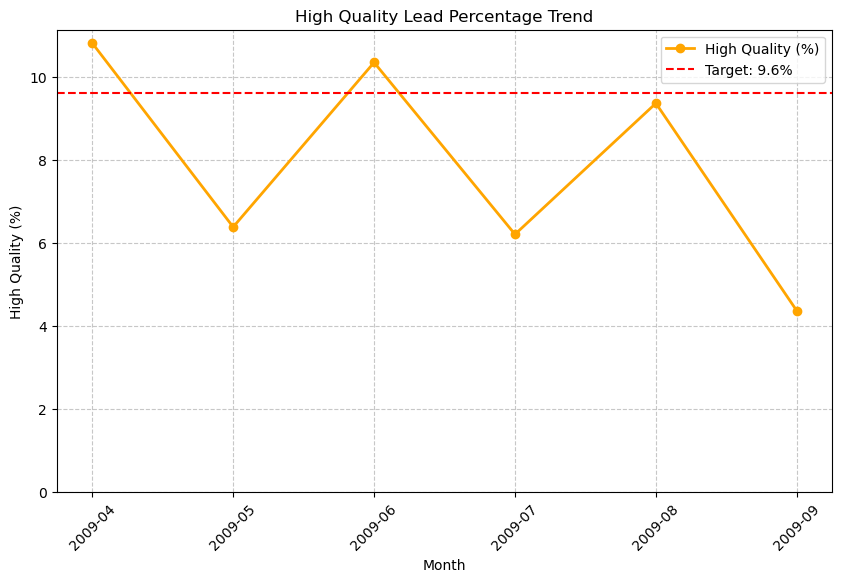

In [343]:
import matplotlib.pyplot as plt

# Compute Lead Quality percentage per month (including "Unknown")
lead_quality_trend = df.groupby(["Month", "LeadQuality"]).size().unstack().fillna(0)

# Calculate percentage for each quality category
lead_quality_trend_percentage = lead_quality_trend.div(lead_quality_trend.sum(axis=1), axis=0) * 100

# Extract High Quality percentage per month
high_quality_percentage = lead_quality_trend_percentage.get("High Quality", 0).reset_index()

# Plot the High Quality Lead Percentage Trend
plt.figure(figsize=(10, 6))
plt.plot(high_quality_percentage["Month"].astype(str), high_quality_percentage["High Quality"], 
         marker="o", linestyle="-", color="orange", linewidth=2, label="High Quality (%)")

# Add horizontal target line at 9.6%
plt.axhline(y=9.6, color="red", linestyle="--", linewidth=1.5, label="Target: 9.6%")

# Formatting
plt.xlabel("Month")
plt.ylabel("High Quality (%)")
plt.title("High Quality Lead Percentage Trend")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.ylim(0, None)  # Set y-axis to start from 0
plt.grid(True, linestyle="--", alpha=0.7)  # Add dashed grid lines
plt.legend()

# Show the plot
plt.show()


In [345]:
# Compute ROI
CPL_values = [30, 33]
revenue_per_conversion = 500
total_leads = len(df_filtered)
high_quality_leads = [total_leads * (8.11/100), total_leads * (9.6/100)]
total_cost = [total_leads * CPL for CPL in CPL_values]
total_revenue = [HQ * revenue_per_conversion for HQ in high_quality_leads]
ROI = [(rev - cost) / cost * 100 for rev, cost in zip(total_revenue, total_cost)]

# Display ROI Results
roi_results = pd.DataFrame({"CPL ($)": CPL_values, "High Quality (%)": [8.11, 9.6], "Total Leads": [total_leads]*2, "High Quality Leads": high_quality_leads, "Total Cost ($)": total_cost, "Total Revenue ($)": total_revenue, "ROI (%)": ROI})

roi_results

,CPL ($),High Quality (%),Total Leads,High Quality Leads,Total Cost ($),Total Revenue ($),ROI (%)
0,30,8.11,881,71.4491,26430,35724.55,35.166667
1,33,9.60,881,84.5760,29073,42288.00,45.454545
